In [ ]:
# The purpose of this code is to perform two objectives: 
# (1) Use cluster analysis to observe anomalies in the stock market from 1880 to 2024.
# (2( Use time series analysis to observe the trends over time.

# Findings:
# The cluster analysis shows there are a mininum of 3 (up to 5) clusters (also called: anomalies) to have happened over the years. 
# The time series analysis shows at least 3 (up to 5) large drops in the stock market over the years.
# I was unsuccessful in predicting future anomalies (all the models used had high MSE and MAE).
# I was curious if I could predict future anomalies (stock market crashes) going to 2100, which does offer a valuable insight.

## 1. Data Collection

In [2]:
pip install xgboost scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

warnings.filterwarnings('ignore')

In [4]:
# Load Data

file_path = 'ie_data.csv'
df = pd.read_csv(file_path)

# It looks like the data needs some cleaning and preprocessing.
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,"Stock Market Data Used in ""Irrational Exuberan...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Robert J. Shiller,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,Consumer,NaN,NaN,NaN,NaN,Real,...,NaN,Monthly,Real,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,S&P,NaN,NaN,Price,NaN,Long,NaN,NaN,Total,...,Excess,Total,Total,10 Year,10 Year,Real 10 Year,NaN,NaN,NaN,NaN


In [5]:
# Basic information shows that we have missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1847 non-null   object 
 1   Unnamed: 1   1848 non-null   object 
 2   Unnamed: 2   1844 non-null   object 
 3   Unnamed: 3   1841 non-null   object 
 4   Unnamed: 4   1849 non-null   object 
 5   Unnamed: 5   1846 non-null   object 
 6   Unnamed: 6   1848 non-null   object 
 7   Unnamed: 7   1846 non-null   object 
 8   Unnamed: 8   1844 non-null   object 
 9   Unnamed: 9   1848 non-null   object 
 10  Unnamed: 10  1841 non-null   object 
 11  Unnamed: 11  1843 non-null   object 
 12  Unnamed: 12  1731 non-null   object 
 13  Unnamed: 13  0 non-null      float64
 14  Unnamed: 14  1731 non-null   object 
 15  Unnamed: 15  0 non-null      float64
 16  Unnamed: 16  1727 non-null   object 
 17  Unnamed: 17  1847 non-null   object 
 18  Unnamed: 18  1848 non-null   object 
 19  Unname

In [6]:
# Clean and Prepare Data

df = df.drop([0, 1, 2, 3, 4, 5]).reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop(0).reset_index(drop=True)
df = df.dropna(axis=1, how='all')

In [7]:
# Rename columns to more descriptive names for easier reference
new_column_names = ['Date', 'S&P Comp.', 'Dividend', 'Earnings', 'CPI', 'Date Fraction', 
                    'Long Interest Rate GS10', 'Real Price', 'Real Dividend', 
                    'Real Total Return Price', 'Real Earnings', 'Real TR Scaled Earnings', 
                    'CAPE', 'TR CAPE', 'Excess CAPE Yield', 'Monthly Total Bond Returns', 
                    'Real Total Bond Returns', '10 Year Annualized Stock Real Return', 
                    '10 Year Annualized Bond Real Return', 'Real 10 Year Annualized Return']
df.columns = new_column_names

df = df.iloc[108:].reset_index(drop=True)
df.drop(columns=['Date Fraction'], inplace=True)

# Convert date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m', errors='coerce')
df.set_index('Date', inplace=True)

In [8]:
# Check DataFrame structure
print(df.index)
print(df.columns)

DatetimeIndex(['1880-01-01', '1880-02-01', '1880-03-01', '1880-04-01',
               '1880-05-01', '1880-06-01', '1880-07-01', '1880-08-01',
               '1880-09-01', '1880-01-01',
               ...
                      'NaT',        'NaT',        'NaT',        'NaT',
                      'NaT',        'NaT',        'NaT',        'NaT',
                      'NaT',        'NaT'],
              dtype='datetime64[ns]', name='Date', length=2362, freq=None)
Index(['S&P Comp.', 'Dividend', 'Earnings', 'CPI', 'Long Interest Rate GS10',
       'Real Price', 'Real Dividend', 'Real Total Return Price',
       'Real Earnings', 'Real TR Scaled Earnings', 'CAPE', 'TR CAPE',
       'Excess CAPE Yield', 'Monthly Total Bond Returns',
       'Real Total Bond Returns', '10 Year Annualized Stock Real Return',
       '10 Year Annualized Bond Real Return',
       'Real 10 Year Annualized Return'],
      dtype='object')


In [9]:
# Check and handle duplicates
duplicates = df.index[df.index.duplicated()]
print("Duplicate dates:", duplicates)
df = df[~df.index.duplicated(keep='first')]

# Resample to monthly frequency and handle missing values
df = df.resample('MS').asfreq()
df.fillna(method='ffill', inplace=True)

Duplicate dates: DatetimeIndex(['1880-01-01', '1881-01-01', '1882-01-01', '1883-01-01',
               '1884-01-01', '1885-01-01', '1886-01-01', '1887-01-01',
               '1888-01-01', '1889-01-01',
               ...
                      'NaT',        'NaT',        'NaT',        'NaT',
                      'NaT',        'NaT',        'NaT',        'NaT',
                      'NaT',        'NaT'],
              dtype='datetime64[ns]', name='Date', length=769, freq=None)


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1737 entries, NaT to 2024-08-01
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   S&P Comp.                             1737 non-null   object
 1   Dividend                              1736 non-null   object
 2   Earnings                              1736 non-null   object
 3   CPI                                   1737 non-null   object
 4   Long Interest Rate GS10               1737 non-null   object
 5   Real Price                            1736 non-null   object
 6   Real Dividend                         1736 non-null   object
 7   Real Total Return Price               1736 non-null   object
 8   Real Earnings                         1736 non-null   object
 9   Real TR Scaled Earnings               1736 non-null   object
 10  CAPE                                  1724 non-null   object
 11  TR CAPE            

In [11]:
# Convert numeric columns
numeric_columns = ['Dividend', 'Earnings', 'CPI', 'Long Interest Rate GS10', 
                    'Real Price', 'Real Dividend', 'Real Total Return Price', 
                    'Real Earnings', 'Real TR Scaled Earnings', 'CAPE', 
                    'TR CAPE', 'Excess CAPE Yield', 'Monthly Total Bond Returns', 
                    'Real Total Bond Returns', '10 Year Annualized Stock Real Return', 
                    '10 Year Annualized Bond Real Return', 'Real 10 Year Annualized Return']

In [12]:
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [13]:
# Drop columns with all NaN values
df.drop(columns=['Excess CAPE Yield', '10 Year Annualized Stock Real Return', 
                 '10 Year Annualized Bond Real Return', 'Real 10 Year Annualized Return'], 
        inplace=True)

# Drop the first row if needed
df = df.iloc[1:]

In [14]:
# Verify if the updated DataFrame has changed
df.head()

,S&P Comp.,Dividend,Earnings,CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,CAPE,TR CAPE,Monthly Total Bond Returns,Real Total Bond Returns
Date,,,,,,,,,,,,,,
1880-01-01,5.11,0.21,0.39,9.99,4.02,160.74,6.45,284.34,12.24,21.66,17.514258,20.934954,1.01,2.14
1880-02-01,5.20,0.21,0.40,9.99,3.99,163.57,6.61,290.33,12.53,22.24,17.514258,20.934954,1.01,2.15
1880-03-01,5.30,0.22,0.41,10.09,3.97,165.14,6.70,294.11,12.70,22.61,17.514258,20.934954,1.01,2.14
1880-04-01,5.18,0.22,0.42,9.70,3.94,167.73,7.12,299.78,13.49,24.12,17.514258,20.934954,1.01,2.24
1880-05-01,4.77,0.23,0.43,9.42,3.91,159.14,7.51,285.54,14.21,25.49,17.514258,20.934954,1.01,2.32


In [15]:
# Save the cleaned DataFrame to a new CSV file
df.to_csv('cleaned_data.csv', index=False)

## 2. Exploratory Data Analysis

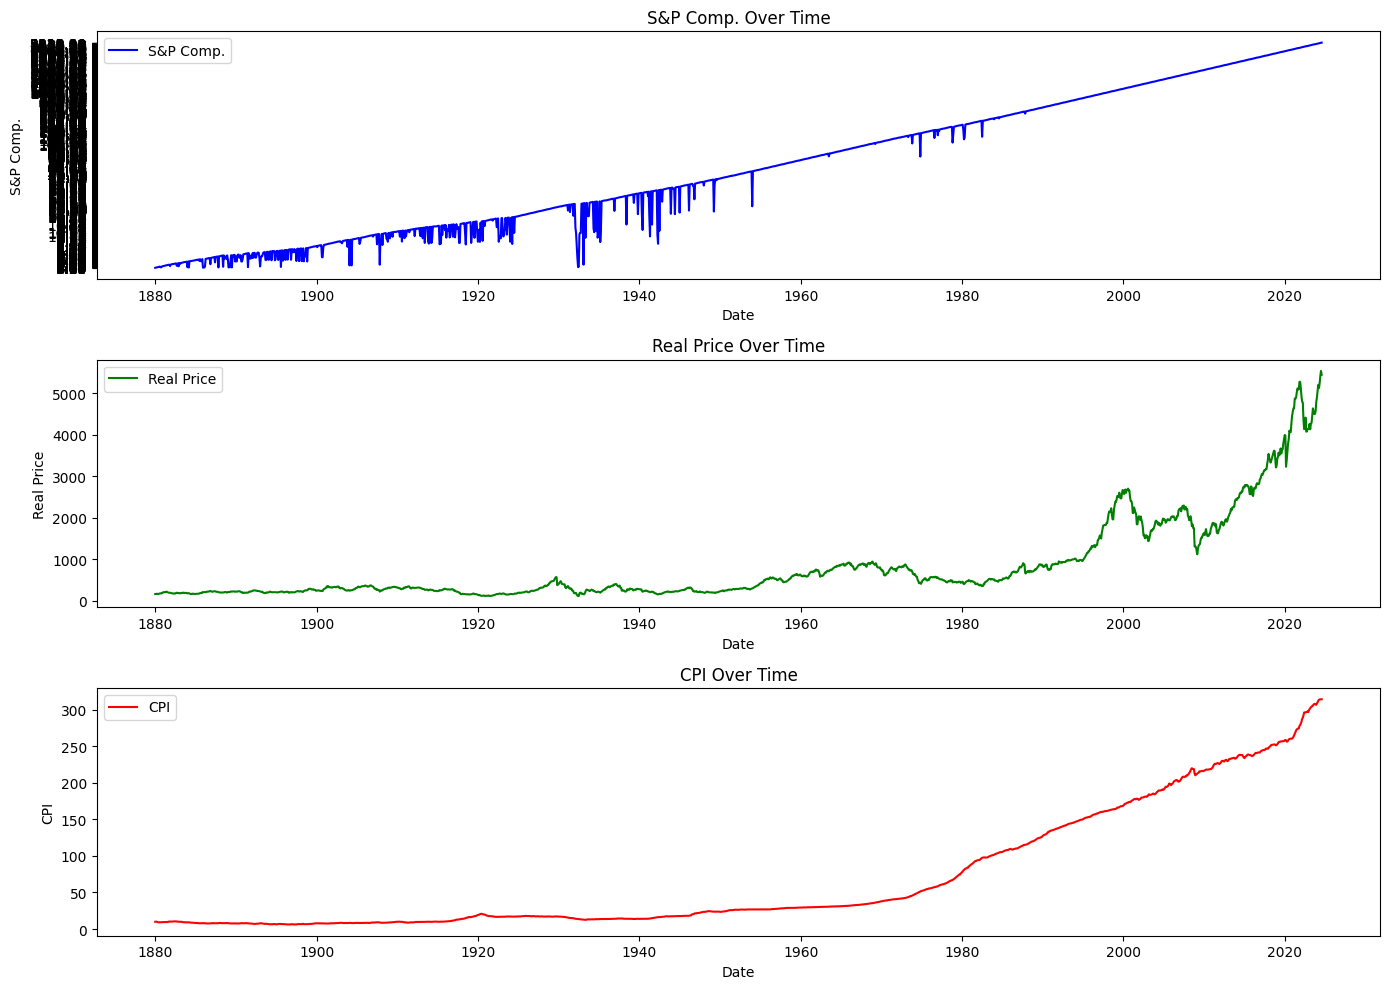

In [17]:
# Visualize key metrics over time

# Plot S&P Composite Index over time
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['S&P Comp.'], label='S&P Comp.', color='blue')
plt.xlabel('Date')
plt.ylabel('S&P Comp.')
plt.title('S&P Comp. Over Time')
plt.legend()

# Plot Real Price over time
plt.subplot(3, 1, 2)
plt.plot(df.index, df['Real Price'], label='Real Price', color='green')
plt.xlabel('Date')
plt.ylabel('Real Price')
plt.title('Real Price Over Time')
plt.legend()

# Plot CPI (Consumer Price Index) over time
plt.subplot(3, 1, 3)
plt.plot(df.index, df['CPI'], label='CPI', color='red')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Interpretation:

# Plot S&P Comp. shows a straight-line growth with regular drops between 1880 and 1940.
# Plot Real Price over time shows a dramatic growth after 1990.
# Plot CPI (Consumer Price Index) show rapid growth after 1980.

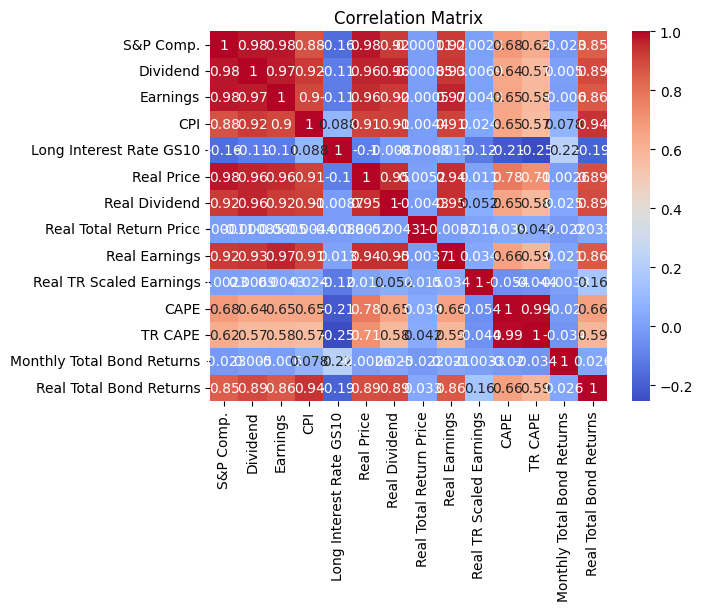

In [19]:
# Correlation Matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
df.corr()

,S&P Comp.,Dividend,Earnings,CPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,CAPE,TR CAPE,Monthly Total Bond Returns,Real Total Bond Returns
S&P Comp.,1.000000,0.978153,0.976001,0.877520,-0.159419,0.977607,0.922843,-0.000108,0.922518,0.002278,0.683321,0.624225,-0.022648,0.846219
Dividend,0.978153,1.000000,0.973629,0.923820,-0.108333,0.962747,0.961679,-0.000853,0.933353,0.006930,0.639801,0.573730,0.004991,0.893830
Earnings,0.976001,0.973629,1.000000,0.899329,-0.112673,0.955589,0.924278,-0.000498,0.965335,0.004303,0.645063,0.581231,-0.005997,0.859302
CPI,0.877520,0.923820,0.899329,1.000000,0.087602,0.909964,0.912266,-0.004438,0.907533,0.023756,0.647117,0.566995,0.078125,0.936417
Long Interest Rate GS10,-0.159419,-0.108333,-0.112673,0.087602,1.000000,-0.104814,-0.008727,-0.008803,0.012616,-0.120135,-0.212086,-0.253118,0.220331,-0.187042
Real Price,0.977607,0.962747,0.955589,0.909964,-0.104814,1.000000,0.948962,0.005235,0.943856,0.011336,0.776417,0.713590,-0.002606,0.885641
Real Dividend,0.922843,0.961679,0.924278,0.912266,-0.008727,0.948962,1.000000,-0.004300,0.945007,0.052403,0.650743,0.577950,0.025372,0.887970
Real Total Return Price,-0.000108,-0.000853,-0.000498,-0.004438,-0.008803,0.005235,-0.004300,1.000000,-0.003701,0.015062,0.038795,0.042414,-0.022312,0.032504
Real Earnings,0.922518,0.933353,0.965335,0.907533,0.012616,0.943856,0.945007,-0.003701,1.000000,0.034355,0.659607,0.586152,0.020804,0.860830
Real TR Scaled Earnings,0.002278,0.006930,0.004303,0.023756,-0.120135,0.011336,0.052403,0.015062,0.034355,1.000000,-0.053534,-0.044177,-0.003315,0.157572


In [21]:
# Interpretation:

# Strong Correlations among the following metrics: 

# S&P Comp. and Real Price (0.977607)
# Dividend and Real Dividend (0.961679)
# Earnings and Real Earnings (0.965335)
# CPI and Real Price (0.909964)

# Plots:

# Real Total Return Price and Real Price (0.943856)
# CAPE and TR CAPE (0.990964)
# Real Total Bond Returns and Real Price (0.885641)

## Clusters

In [23]:
# Define the columns used for PCA based on the DataFrame
numeric_columns = [
    'S&P Comp.',
    'Dividend',
    'Earnings',
    'CPI',
    'Long Interest Rate GS10',
    'Real Price',
    'Real Dividend',
    'Real Total Return Price',
    'Real Earnings',
    'Real TR Scaled Earnings',
    'CAPE',
    'TR CAPE',
    'Monthly Total Bond Returns',
    'Real Total Bond Returns'
]

# Ensure columns exist
missing_cols = [col for col in numeric_columns if col not in df.columns]
if missing_cols:
    raise KeyError(f"Columns not found in DataFrame: {missing_cols}")

In [24]:
# Data Scaling and PCA

# Apply StandardScaler to normalize data before performing PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_columns])

# Perform Principal Component Analysis (PCA) to reduce dimensionality
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Check to see if PCA transformation was successful
print("PCA result shape:", pca_result.shape)

PCA result shape: (1736, 2)


In [25]:
# K-means Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans Cluster'] = kmeans.fit_predict(pca_result)

In [26]:
# DBSCAN Clustering

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN Cluster'] = dbscan.fit_predict(pca_result)

In [27]:
# Define function to perform Kmean clustering
def kmeans_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    return kmeans 

In [28]:
# Define function to perform DBSCAN clustering
def dbscan_clustering(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)
    return dbscan

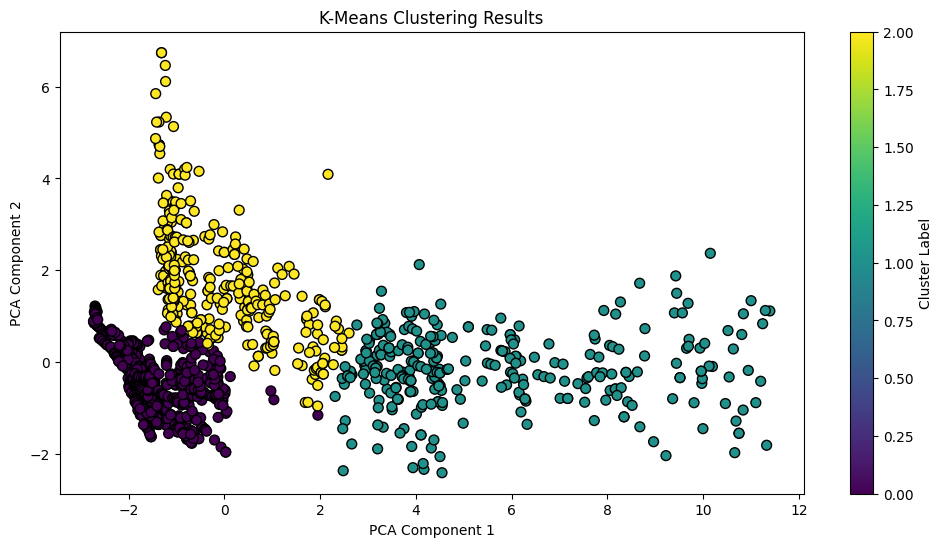

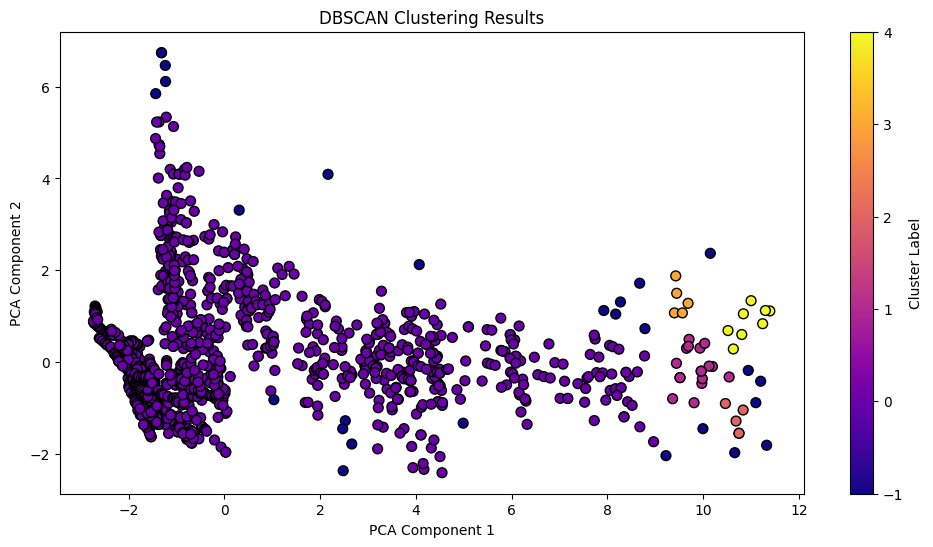

In [29]:
# Visualize K-Means Clusters
plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['KMeans Cluster'], cmap='viridis', edgecolor='k', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Results')
plt.colorbar(label='Cluster Label')
plt.show()

# Visualize DBSCAN Clusters
plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['DBSCAN Cluster'], cmap='plasma', edgecolor='k', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering Results')
plt.colorbar(label='Cluster Label')
plt.show()

In [30]:
# Evaluate the Clustering Results

# Define function to plot the Elbow curve
def plot_elbow(X, max_k):
    ssd = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        ssd.append(kmeans.inertia_)
    plt.figure()
    plt.plot(range(1, max_k + 1), ssd, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method')
    plt.show()

In [31]:
# Define function to evaluate K-Means clustering using silhouette score
def evaluate_kmeans(X, n_clusters):
    kmeans = kmeans_clustering(X, n_clusters)
    labels = kmeans.labels_  
    score = silhouette_score(X, labels) 
    return kmeans, score

In [32]:
# Define function to evaluate DBSCAN clustering using silhouette score
# DBSCAN with only one cluster or noise
def evaluate_dbscan(X, eps, min_samples):
    dbscan = dbscan_clustering(X, eps, min_samples)
    labels = dbscan.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
    else:
        score = -1 
    return dbscan, score

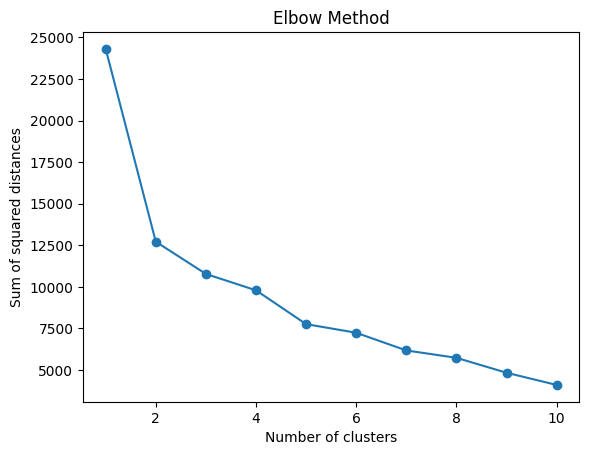

In [33]:
# Plot the elbow curve for K-Means
max_k = 10
plot_elbow(df_scaled, max_k)

In [34]:
# Evaluate K-Means clustering
kmeans, kmeans_score = evaluate_kmeans(df_scaled, n_clusters=4)

# Evaluate DBSCAN Clustering
eps = 0.5
min_samples = 5
dbscan, dbscan_score = evaluate_dbscan(df_scaled, eps, min_samples)

# Compare Silhouette Scores
print("\nComparing Cluster Scores :")
print(f"K-Means Silhouette Score: {kmeans_score:.4f}")
print(f"DBSCAN Silhouette Score: {dbscan_score:.4f}")


Comparing Cluster Scores :
K-Means Silhouette Score: 0.2322
DBSCAN Silhouette Score: -0.1160


In [35]:
# Determine the best model based on silhouette score
best_model = 'K-Means' if kmeans_score > dbscan_score else 'DBSCAN'

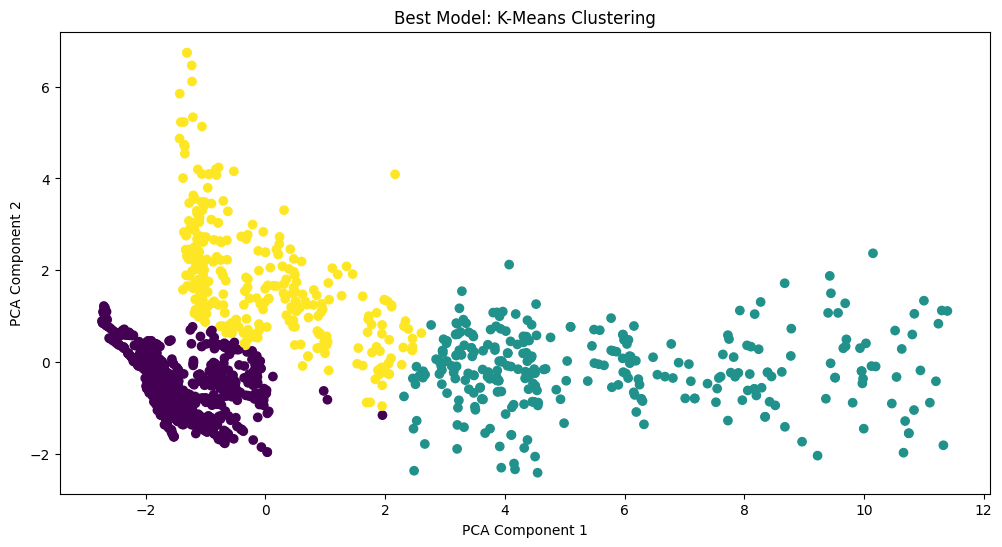

In [36]:
# Visualize the Best Model's Clusters

plt.figure(figsize=(12, 6))
if best_model == 'K-Means':
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['KMeans Cluster'], cmap='viridis')
    plt.title('Best Model: K-Means Clustering')
else:
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['DBSCAN Cluster'], cmap='plasma')
    plt.title('Best Model: DBSCAN Clustering')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [37]:
# ===== The Best Model =====

# K-Mean Clustering provided the best model.
# Positive Score (0.2322)indicates that points are somewhat clustered into three clusters. 
# In general, a silhouette score above 0.5 is considered good, which indicates that clustering quality is moderate.
# The Elbow Method also suggests three clusters, but this inconclusive and also suggests more clusters.

## Time Series Analysis

In [39]:
# Create lag features to represent the past values of the time series

# Ensure 'S&P Comp' column is numeric and without missing values
df['S&P Comp.'] = pd.to_numeric(df['S&P Comp.'], errors='coerce')
df.dropna(subset=['S&P Comp.'], inplace=True)

# Create lag features for the 'S&P Comp' column
df['Lag_1'] = df['S&P Comp.'].shift(1)
df['Lag_2'] = df['S&P Comp.'].shift(2)
df['Lag_3'] = df['S&P Comp.'].shift(3)
df['Lag_4'] = df['S&P Comp.'].shift(4)
df['Lag_5'] = df['S&P Comp.'].shift(5)

# Create rolling features
df['Rolling_Mean_3'] = df['S&P Comp.'].rolling(window=3).mean()
df['Rolling_Std_3'] = df['S&P Comp.'].rolling(window=3).std()

# Drop rows with missing values due to lagging
df.dropna(inplace=True)

In [40]:
# Prepare data for training and testing
X = df[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Rolling_Mean_3', 'Rolling_Std_3']]
y = df['S&P Comp.']

# Split data into training and test sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [41]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest with Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [42]:
# Train the Random Forest Model

rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)
print("Best parameters for Random Forest:", rf_grid_search.best_params_)

# Train and evaluate Random Forest on the test set
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest Test MSE: {mse_rf}')
print(f'Random Forest Test MAE: {mae_rf}')

Best parameters for Random Forest: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Test MSE: 3109204.217997211
Random Forest Test MAE: 1332.5559210374633


In [43]:
# Train and Evaluate XGBoost Model with k-Fold Cross-Validation

# XGBoost with Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train_scaled, y_train)
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [44]:
# Train and evaluate XGBoost on the test set
xgb_best_model = xgb_grid_search.best_estimator_
y_pred_xgb = xgb_best_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'XGBoost Test MSE: {mse_xgb}')
print(f'XGBoost Test MAE: {mae_xgb}')

XGBoost Test MSE: 3087027.4121173956
XGBoost Test MAE: 1323.9934049033568


In [45]:
# Train ARIMA model
model = ARIMA(y_train, order=(5, 1, 0))  # Adjust the order as needed
model_fit = model.fit()

# Forecast on the test set
forecast_arima = model_fit.forecast(steps=len(y_test))

# Calculate metrics for ARIMA
mse_arima = mean_squared_error(y_test, forecast_arima)
mae_arima = mean_absolute_error(y_test, forecast_arima)

print(f'ARIMA Test MSE: {mse_arima}')
print(f'ARIMA Test MAE: {mae_arima}')

ARIMA Test MSE: 3049523.3425176702
ARIMA Test MAE: 1309.9122685860802


In [46]:
# ===== COMPARE MODELS AND DISPLAY RESULTS =====

# Summary of results
print("\nModel Comparison:")
print(f"ARIMA MSE: {mse_arima}, MAE: {mae_arima}")
print(f"Random Forest Test MSE: {mse_rf}, Test MAE: {mae_rf}")
print(f"XGBoost Test MSE: {mse_xgb}, Test MAE: {mae_xgb}")


Model Comparison:
ARIMA MSE: 3049523.3425176702, MAE: 1309.9122685860802
Random Forest Test MSE: 3109204.217997211, Test MAE: 1332.5559210374633
XGBoost Test MSE: 3087027.4121173956, Test MAE: 1323.9934049033568


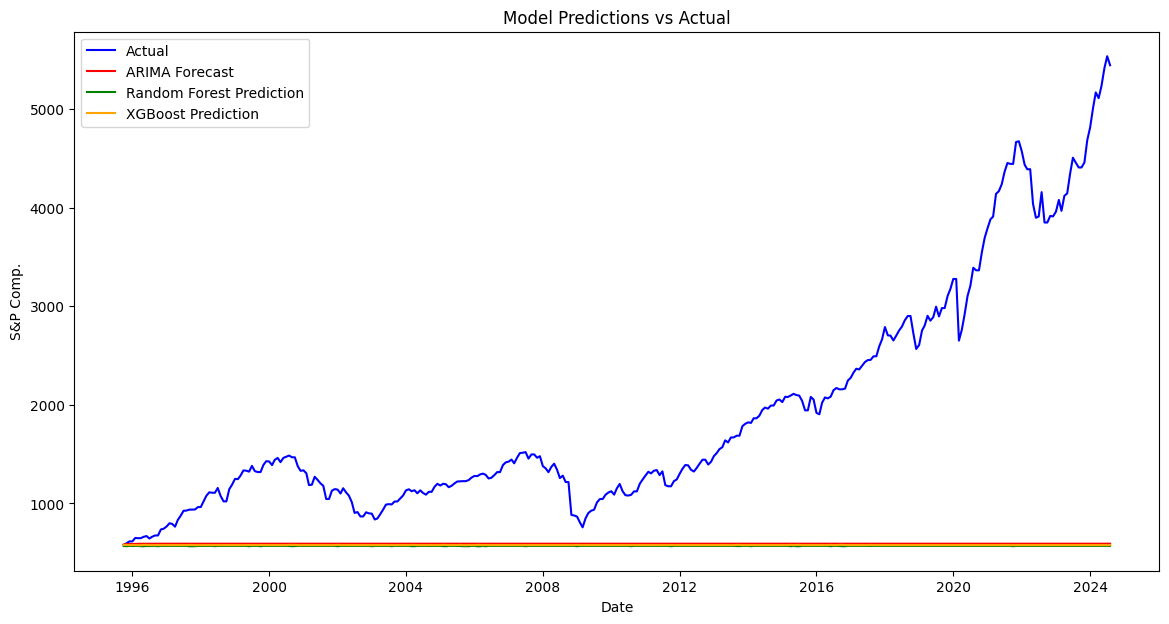

In [47]:
# Visualize the predictions made by each model
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size:], y_test, label='Actual', color='blue')
plt.plot(df.index[train_size:], forecast_arima, label='ARIMA Forecast', color='red')
plt.plot(df.index[train_size:], y_pred_rf, label='Random Forest Prediction', color='green')
plt.plot(df.index[train_size:], y_pred_xgb, label='XGBoost Prediction', color='orange')
plt.xlabel('Date')
plt.ylabel('S&P Comp.')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.show()

In [48]:
# ===== The Best Model =====

# ARIMA has the lowest MSE and MSA, making it the best model.
# The XGBoost model has a lower cross-validated MSE compared to the Random Forest model
# The Random Forest model has a highest MSE and MSA compare to the other models.

# However, the code was unsuccessful in predicting a forecast into the future. 
# The evaluation metrics suggests prediction errors.

# Random Forest
# Cross-validated MSE is a small, which shows a good performance
# Test MSE is too large (compared to the cross-validated MSE)
# Test MAE is also too large

# XGBoost
# Cross-validated MSE is a small
# Test MSE is too large (compared to the cross-validated MSE)
# Test MAE is also too large

# Test MSE is too high
# Test MAE is too high

# This model used hypterparameter tuning for Random Forest and XGBoost with GridSearch.
# The model tuning included adding more lag features and rolling statistics.
# Despite these efforts, the model's evaluation metrics did not score well.